In [1]:
import joblib

all_label_dic = joblib.load("../Celltype_Annotations/all_label_dic.pkl")
encoders = joblib.load("../Celltype_Annotations/label_encoders.pkl")

In [2]:
import numpy as np

def update_skin_subregion(df):
    """
    Update subregion labels for skin ('SK') entries with missing or 'other'-like values.
    Replaces them with a unified label: 'Skin_other'.

    Args:
        df (pd.DataFrame): DataFrame containing 'organ' and 'subregion' columns.

    Returns:
        tuple: (updated DataFrame, number of rows updated)
    """
    # Condition: organ is 'SK' and subregion is NA or 'other' (case-insensitive)
    condition = (df['organ'] == 'SK') & (
        df['subregion'].isna() | (df['subregion'].astype(str).str.lower() == 'other')
    )
    num_updated = condition.sum()

    # Apply the replacement
    df.loc[condition, 'subregion'] = 'Skin_other'
    return df, num_updated

# Plot

In [3]:
batch_list = ['CTRL_1', 'CTRL_2', 'LPS_1', 'LPS_2']

Confusion matrix saved to: ../Celltype_Annotations/organ_loocv_confusion_matrix_CTRL_1.csv
Confusion matrix saved to: ../Celltype_Annotations/organ_loocv_confusion_matrix_CTRL_2.csv
Confusion matrix saved to: ../Celltype_Annotations/organ_loocv_confusion_matrix_LPS_1.csv
Confusion matrix saved to: ../Celltype_Annotations/organ_loocv_confusion_matrix_LPS_2.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/subregion_loocv_confusion_matrix_CTRL_1.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/subregion_loocv_confusion_matrix_CTRL_2.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/subregion_loocv_confusion_matrix_LPS_1.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/subregion_loocv_confusion_matrix_LPS_2.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/level2_annotation_loocv_confusion_matrix_CTRL_1.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/level2_annotation_loocv_confusion_matrix_CTRL_2.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/level2_annotation_loocv_confusion_matrix_LPS_1.csv


/tmp/ipykernel_739167/1576659489.py:46: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Confusion matrix saved to: ../Celltype_Annotations/level2_annotation_loocv_confusion_matrix_LPS_2.csv


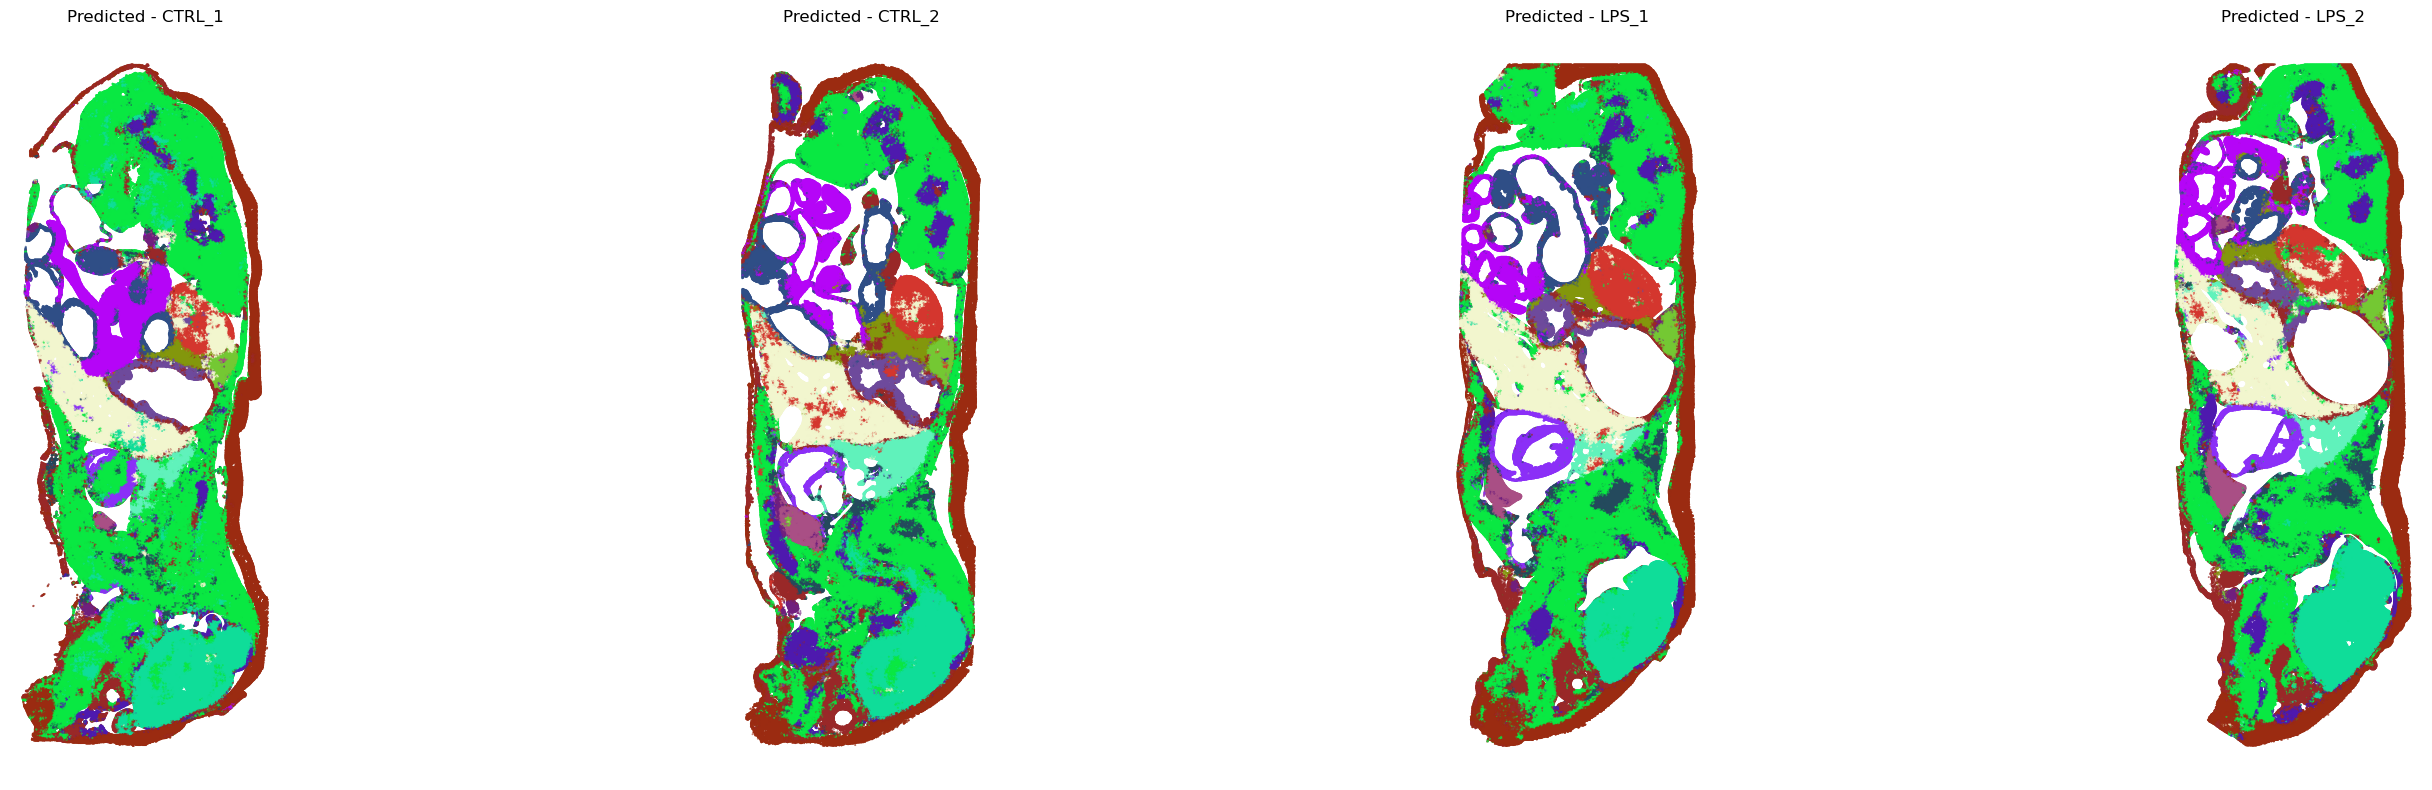

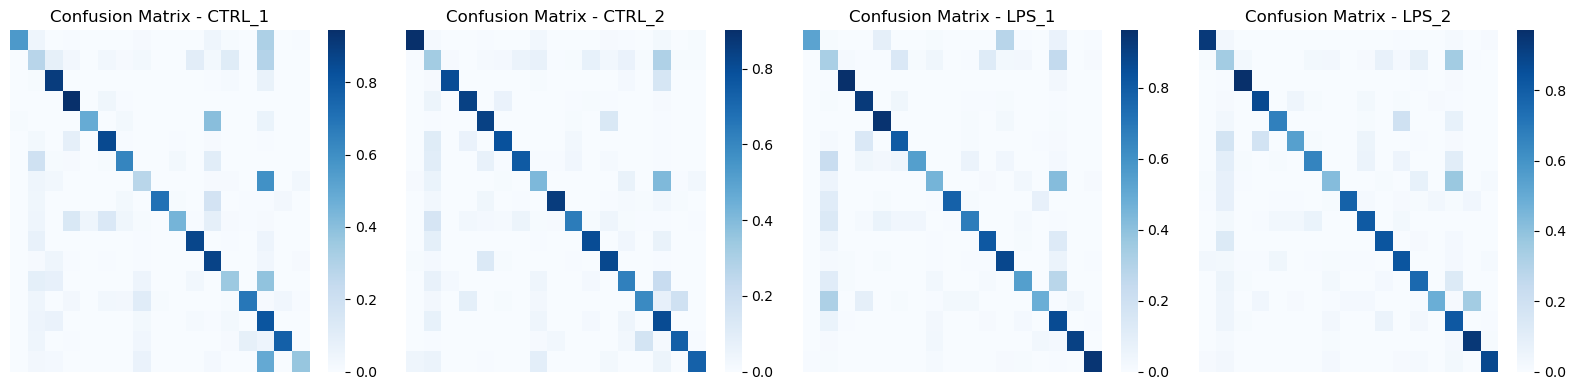

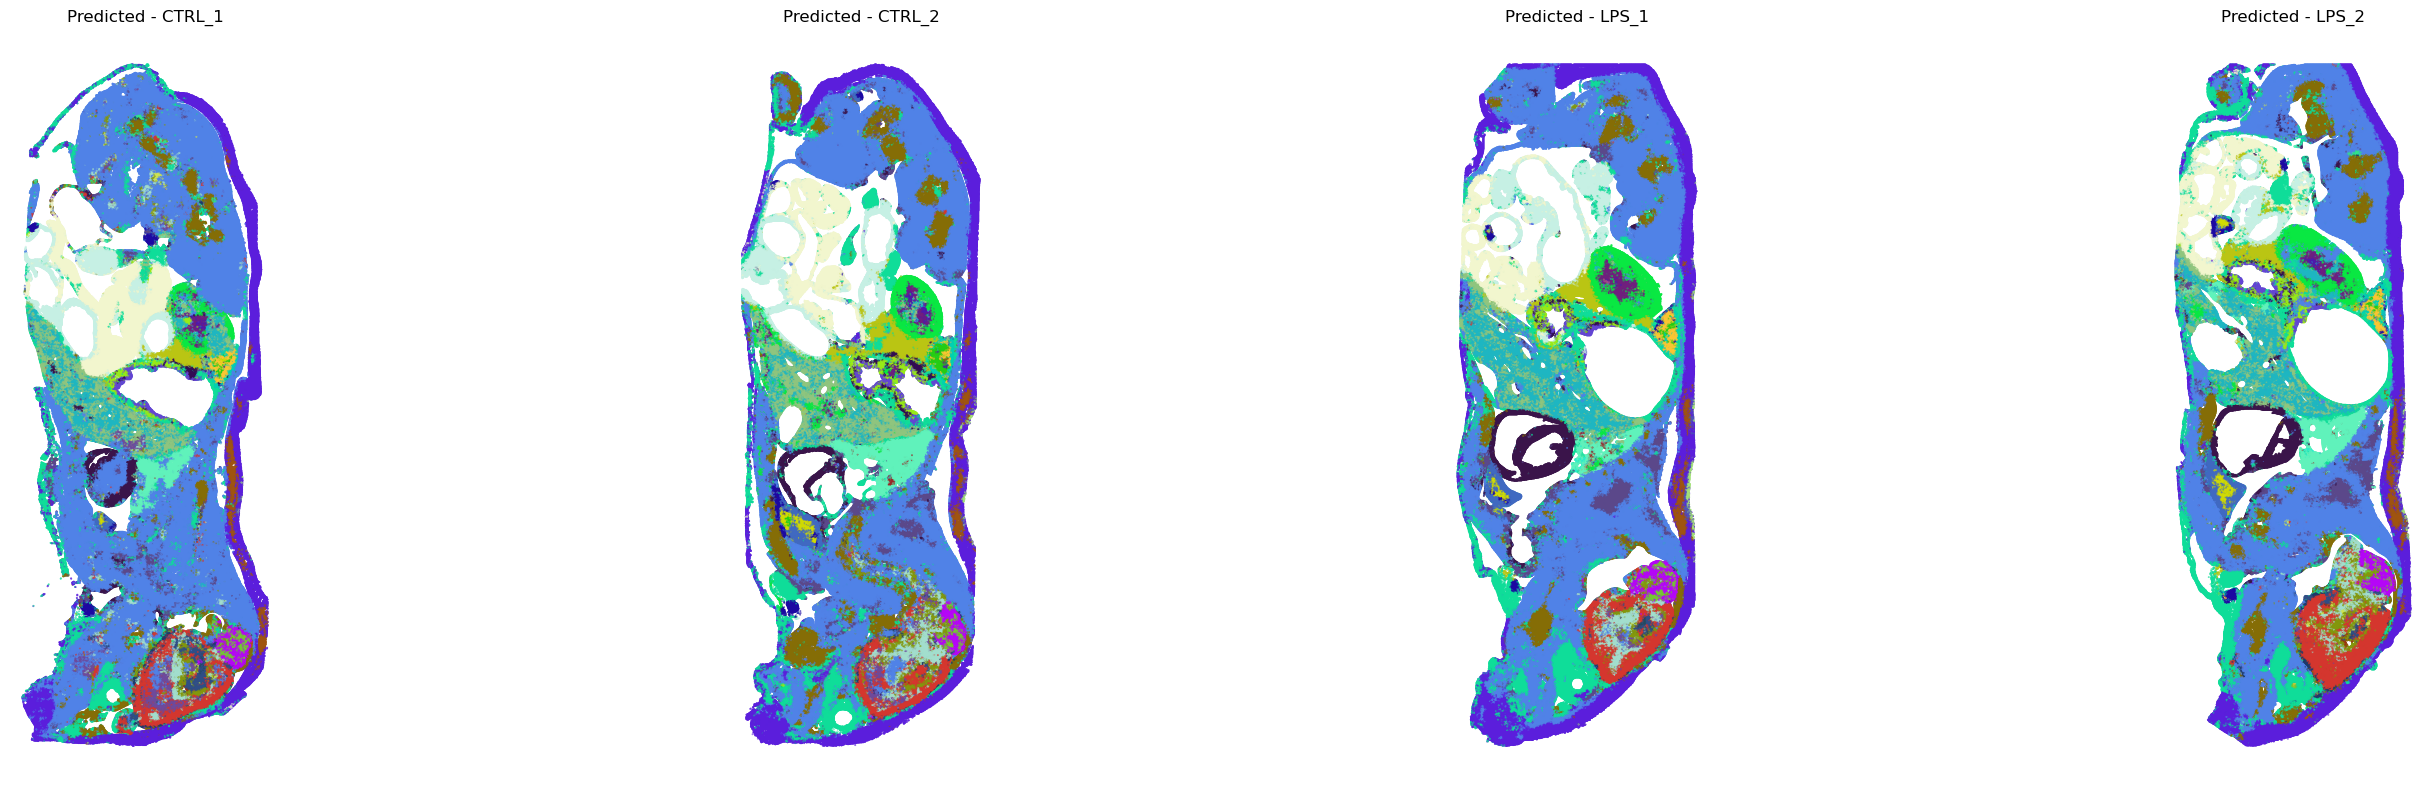

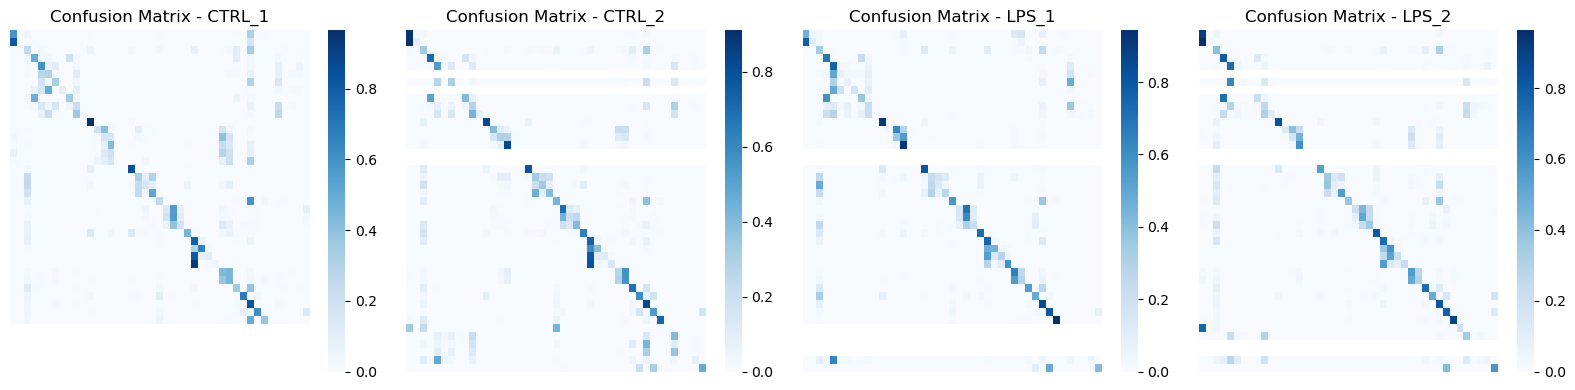

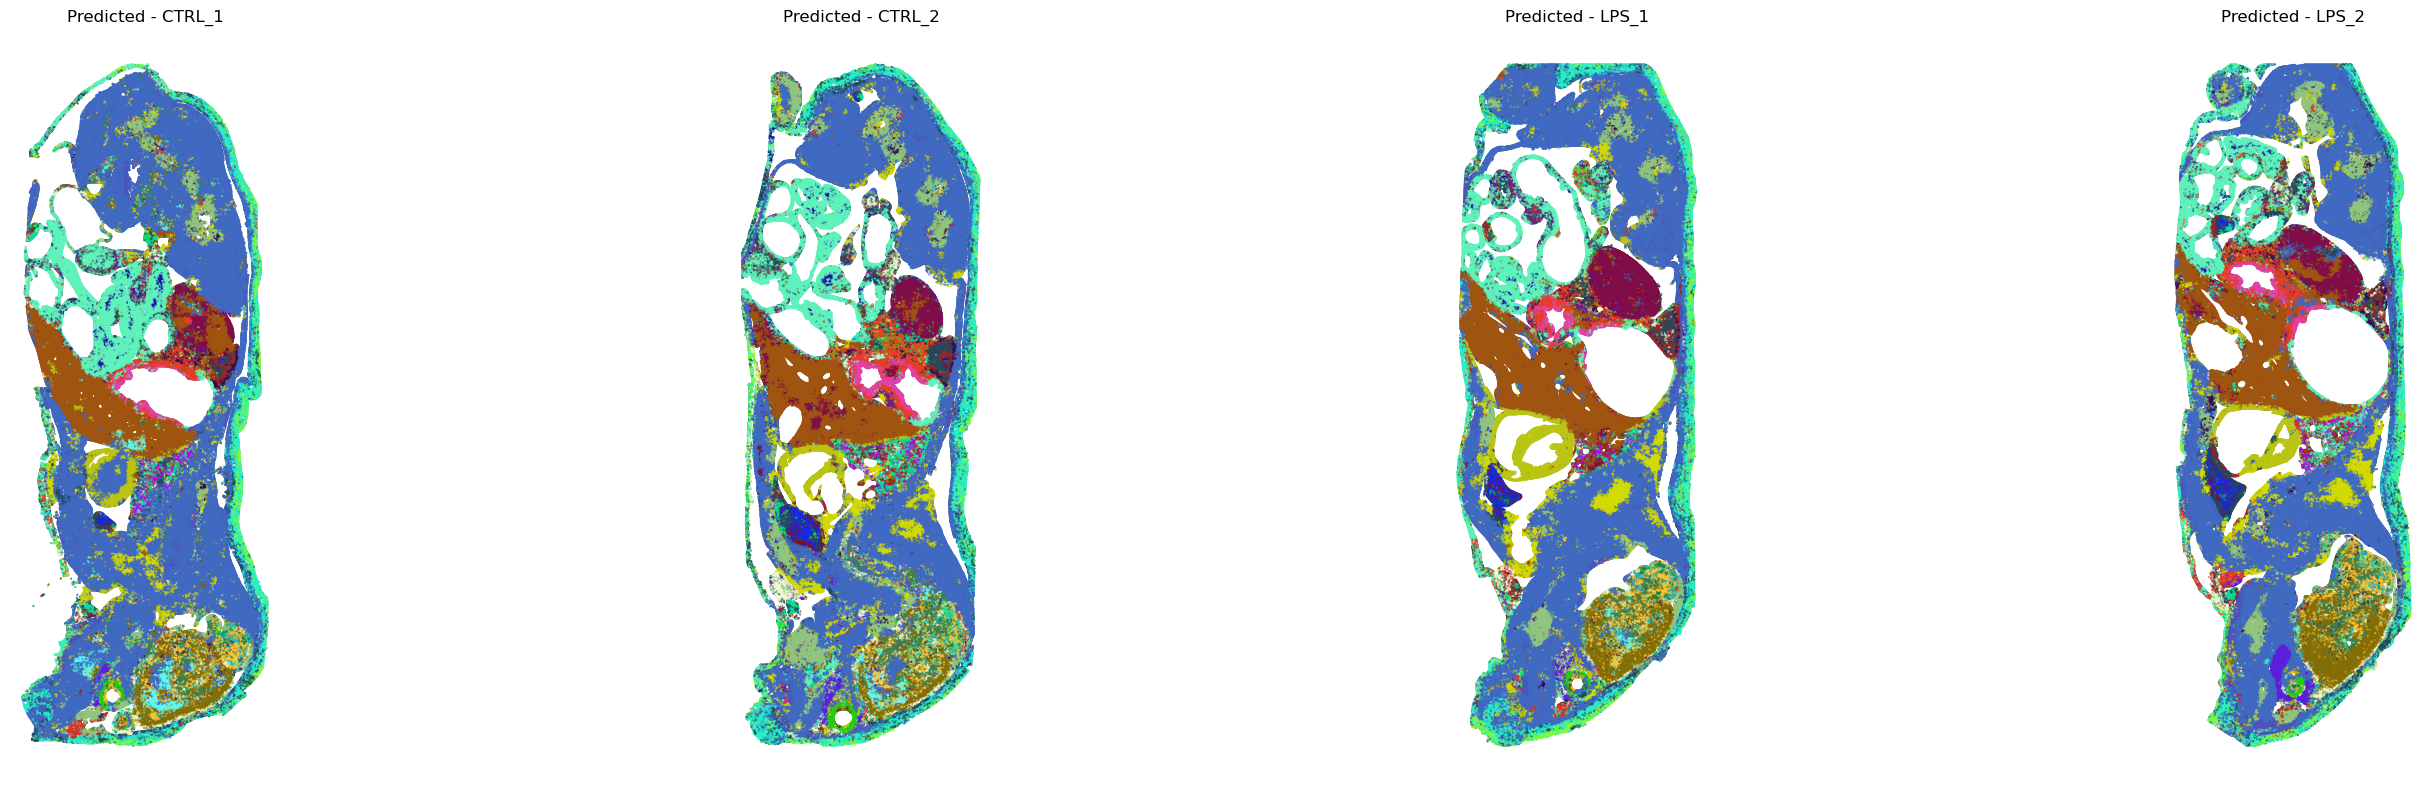

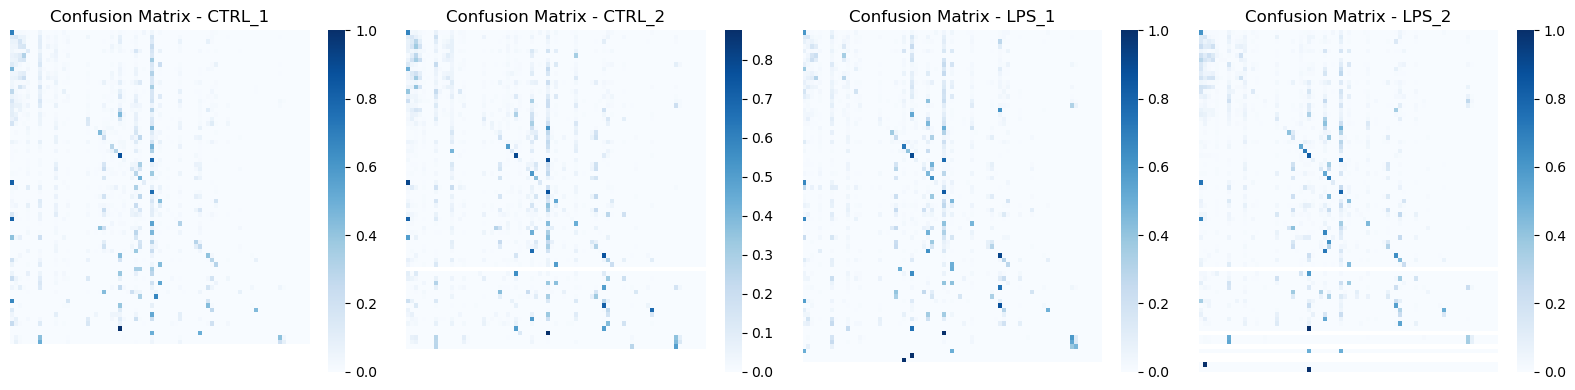

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np 

patch_size = 128
# Iterate through all hierarchical annotation levels
for label in ['organ', 'subregion', 'level2_annotation']:
    all_labels = all_label_dic[label]  # Full set of possible labels for the current level

    # Generate a consistent random color mapping for the labels
    np.random.seed(42)
    num_labels = len(all_labels)
    colors = np.random.rand(num_labels, 3)  # RGB colors in [0, 1]
    label_color_mapping = {label: colors[i] for i, label in enumerate(all_labels)}

    # Create subplot grid for predicted label visualization
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(32, 8))
    axes = axes.flatten()

    # Create subplot grid for confusion matrix heatmaps
    fig_cm, axes_cm = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    axes_cm = axes_cm.flatten()

    # Iterate through batches
    for i, batch in enumerate(batch_list):
        # Load predicted and ground truth label info
        pred_info = pd.read_csv(f"/home/lbh/projects_dir/BigSlice/evalset/uni_prediction_{batch}_LOOCV.csv")
        label_info = pd.read_csv(f"/home/lbh/projects_dir/BigSlice/evalset/uni_prediction_{batch}_LOOCV.csv")

        # Plot spatial distribution of predicted labels
        x_pred, y_pred = pred_info['x_scaled_image'], pred_info['y_scaled_image']
        color_pred = [label_color_mapping.get(lbl, "black") for lbl in pred_info[f"{label}_pred"]]
        axes[i].scatter(x_pred, y_pred, c=color_pred, s=0.1)
        axes[i].set_title(f"Predicted - {batch}", fontsize=12)
        axes[i].set_aspect(1)
        axes[i].axis("off")

        # Compute and normalize the confusion matrix
        true_labels = label_info[label]
        pred_labels = pred_info[f"{label}_pred"]
        cm = confusion_matrix(true_labels, pred_labels, labels=list(label_color_mapping.keys()))
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        # Plot confusion matrix heatmap
        sns.heatmap(cm_normalized, annot=False, cmap="Blues", ax=axes_cm[i],
                    xticklabels=False, yticklabels=False)
        axes_cm[i].set_title(f"Confusion Matrix - {batch}")
        axes_cm[i].set_xlabel('')
        axes_cm[i].set_ylabel('')
        axes_cm[i].tick_params(axis='both', which='both', length=0)

        # Save confusion matrix to CSV
        cm_df = pd.DataFrame(
            cm_normalized,
            index=[f"True: {name}" for name in label_color_mapping.keys()],
            columns=[f"Pred: {name}" for name in label_color_mapping.keys()]
        )
        cm_csv_path = f'../Celltype_Annotations/{label}_loocv_confusion_matrix_{batch}.csv'
        cm_df.to_csv(cm_csv_path)
        print(f"Confusion matrix saved to: {cm_csv_path}")

    # Save spatial prediction figure
    fig.tight_layout()
    fig.savefig(f'../Celltype_Annotations/{label}_loocv_region_prediction.pdf', transparent=True)
    fig.show()

    # Save confusion matrix figure
    fig_cm.tight_layout()
    fig_cm.savefig(f'../Celltype_Annotations/{label}_loocv_confusion_matrices.pdf', transparent=True)
    fig_cm.show()
